## Forest Cover Type Prediction

## Project Overview

This notebook explores the prediction of forest cover types using machine learning techniques on the Covertype dataset. The primary goal is to develop and compare models, including Random Forest, XGBoost, and a Neural Network, to achieve high accuracy and robustness. The workflow includes data preprocessing (scaling numerical features and removing outliers), model training and evaluation, and visualization of results. Key steps involve handling the imbalanced dataset with class weights, tuning hyperparameters for XGBoost, and deploying the best model. The project aims to deliver a tuned XGBoost model with an accuracy of approximately 0.96, alongside visualizations like confusion matrices and a model comparison plot, making it suitable for a portfolio demonstration of machine learning skills.


## Dataset Description

This project utilizes the **Covertype Dataset** from the UCI Machine Learning Repository, which contains cartographic data to predict forest cover types in a region of Roosevelt National Forest in northern Colorado, USA. The dataset includes 581,012 samples with 54 features, comprising 10 quantitative variables (e.g., elevation, slope, distance to water) and 44 binary variables encoding soil type and wilderness area. The target variable, `Cover_Type`, represents seven forest cover types (Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, and Krummholz), ranging from 1 to 7 (adjusted to 0-6 in this analysis). The dataset exhibits class imbalance, with Spruce/Fir and Lodgepole Pine dominating, while Aspen and Cottonwood/Willow are underrepresented, necessitating techniques like class weighting for balanced model performance

## Algorithms Description
**Random Forest**: An ensemble method that constructs multiple decision trees during training and outputs the mode of their predictions. It handles imbalanced data well with class weights and is robust against overfitting due to its averaging approach. Used here as a baseline model with 100 trees.\n",
    "\n",
    "- **XGBoost**: An optimized gradient boosting framework that builds sequential decision trees, minimizing errors from previous trees. It includes regularization to prevent overfitting and supports class weighting. Tuned with GridSearchCV to optimize parameters like `max_depth` and `n_estimators`, achieving superior performance.\n",
    "\n",
    "- **Neural Network**: A deep learning model with multiple dense layers, including batch normalization and dropout for regularization. Trained with TensorFlow/Keras, it uses a softmax output for multi-class classification and early stopping to prevent overfitting. Applied with class weights to address imbalance, though it underperforms compared to tree-based methods here.

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
df = pd.read_csv('covtype.csv')

In [3]:
columns = df.columns

In [4]:
df['Cover_Type'].value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

In [5]:
# Separate features and target
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type'] - 1  # Adjust to 0-6 for zero-based indexing

In [6]:
# Identify numerical features
num_features = columns[:10]

# Scale numerical features
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])

In [7]:
# Handle outliers using z-scores (>3)
z_scores = np.abs(stats.zscore(X[num_features]))
outlier_mask = (z_scores < 3).all(axis=1)
X = X[outlier_mask]
y = y[outlier_mask]

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Compute class weights for imbalanced classes
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [9]:
# Baseline Model: Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [10]:
# Evaluate Random Forest
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average="macro")
print('Random Forest Baseline:')
print(f'Accuracy: {rf_accuracy:.2f}')
print(f'Macro F1-Score: {rf_f1:.2f}')
print(classification_report(y_test, y_pred_rf))

Random Forest Baseline:
Accuracy: 0.95
Macro F1-Score: 0.92
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     40143
           1       0.95      0.97      0.96     53018
           2       0.94      0.96      0.95      5582
           3       0.92      0.88      0.90       414
           4       0.94      0.75      0.83      1683
           5       0.92      0.90      0.91      2911
           6       0.97      0.94      0.96      3536

    accuracy                           0.95    107287
   macro avg       0.95      0.91      0.92    107287
weighted avg       0.95      0.95      0.95    107287



In [11]:
# Advanced Model: XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [12]:
# Evaluate Initial XGBoost
xgb_initial_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_initial_f1 = f1_score(y_test, y_pred_xgb, average="macro")
print('XGBoost Initial:')
print(f'Accuracy: {xgb_initial_accuracy:.2f}')
print(f'Macro F1-Score: {xgb_initial_f1:.2f}')
print(classification_report(y_test, y_pred_xgb))

XGBoost Initial:
Accuracy: 0.87
Macro F1-Score: 0.85
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     40143
           1       0.87      0.90      0.88     53018
           2       0.89      0.90      0.90      5582
           3       0.92      0.89      0.90       414
           4       0.86      0.55      0.67      1683
           5       0.85      0.83      0.84      2911
           6       0.95      0.91      0.93      3536

    accuracy                           0.87    107287
   macro avg       0.89      0.83      0.85    107287
weighted avg       0.87      0.87      0.87    107287



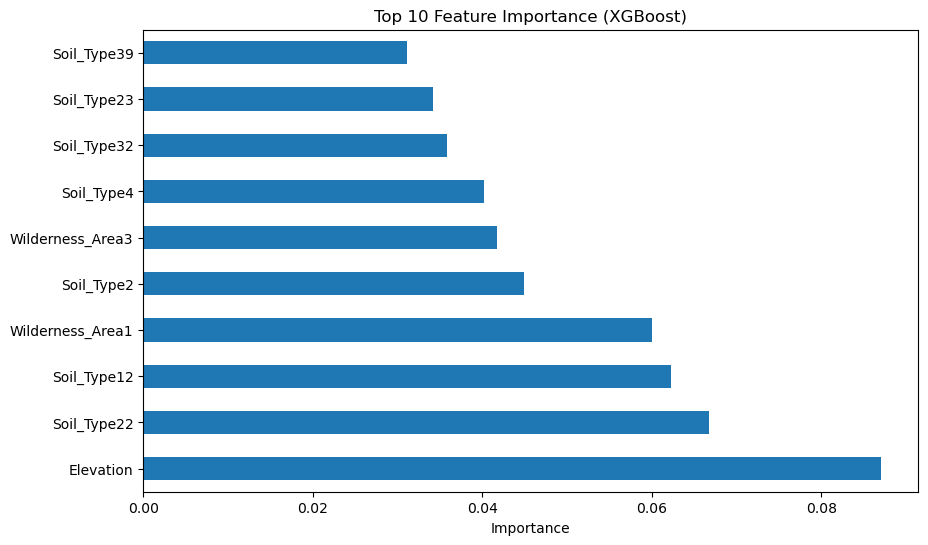

In [13]:
# Visualize Feature Importance (XGBoost)
feature_importance = pd.Series(xgb_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importance.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importance (XGBoost)')
plt.xlabel('Importance')
plt.savefig('feature_importance_initial.png')
plt.show()

In [14]:
# Define parameter grid
param_grid = {
    'learning_rate': [ 0.1],
    'max_depth': [ 10,20],
    'n_estimators': [300, 400],
    'subsample': [0.8, 1.0]
}


In [15]:
from sklearn.model_selection import GridSearchCV

# Grid search
xgb_tuned = xgb.XGBClassifier(random_state=42)
grid_search = GridSearchCV(xgb_tuned, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': [10, 20],
                         'n_estimators': [300, 400], 'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [16]:
# Best parameters and score
print('Best Parameters from GridSearchCV:', grid_search.best_params_)
print('Best Cross-Validation Accuracy:', grid_search.best_score_)

Best Parameters from GridSearchCV: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 400, 'subsample': 1.0}
Best Cross-Validation Accuracy: 0.9678709244449415


In [17]:
# Retrain on full training data with best parameters
best_xgb = xgb.XGBClassifier(**grid_search.best_params_, random_state=42)
best_xgb.fit(X_train, y_train)
y_pred_xgb_tuned = best_xgb.predict(X_test)


In [18]:
# Evaluate Tuned XGBoost
xgb_tuned_accuracy = accuracy_score(y_test, y_pred_xgb_tuned)
xgb_tuned_f1 = f1_score(y_test, y_pred_xgb_tuned, average="macro")
print('XGBoost Tuned:')
print(f'Accuracy: {xgb_tuned_accuracy:.2f}')
print(f'Macro F1-Score: {xgb_tuned_f1:.2f}')
print(classification_report(y_test, y_pred_xgb_tuned))

XGBoost Tuned:
Accuracy: 0.97
Macro F1-Score: 0.95
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     40143
           1       0.98      0.98      0.98     53018
           2       0.97      0.97      0.97      5582
           3       0.92      0.89      0.91       414
           4       0.93      0.88      0.90      1683
           5       0.94      0.95      0.95      2911
           6       0.97      0.96      0.97      3536

    accuracy                           0.97    107287
   macro avg       0.96      0.94      0.95    107287
weighted avg       0.97      0.97      0.97    107287



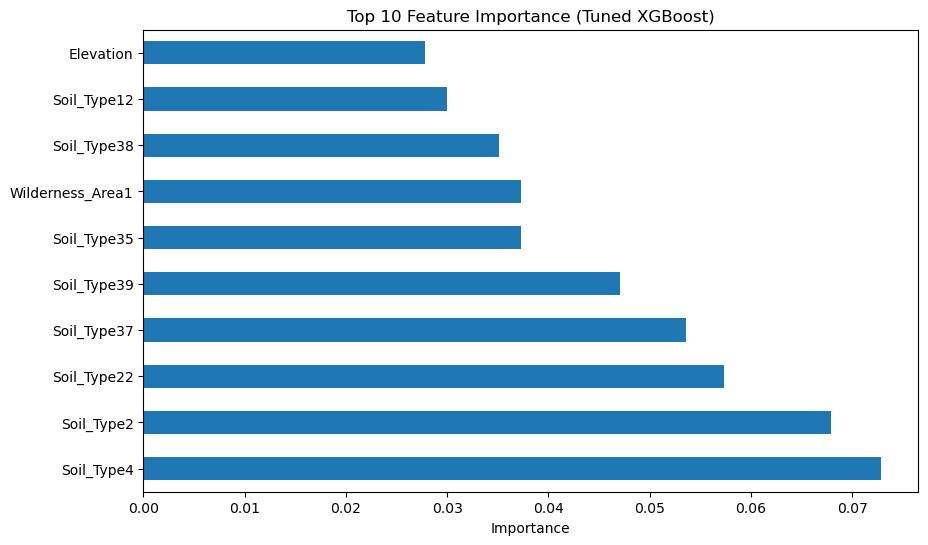

In [19]:
# Visualize Feature Importance (Tuned XGBoost)
feature_importance_tuned = pd.Series(best_xgb.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importance_tuned.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importance (Tuned XGBoost)')
plt.xlabel('Importance')
plt.savefig('feature_importance_tuned.png')
plt.show()


In [21]:
import joblib

# Save the best model
joblib.dump(best_xgb, 'best_xgb_model.pkl')
print("Tuned XGBoost model saved as 'best_xgb_model.pkl'")


Tuned XGBoost model saved as 'best_xgb_model.pkl'


# Neural Network Model with TensorFlow/Keras

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# One-hot encode target for neural network
y_train_nn = to_categorical(y_train)
y_test_nn = to_categorical(y_test)

In [23]:
# Build enhanced model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(7, activation='softmax')  # 7 classes
])

C:\Users\kimkm\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [26]:
# Train model
history = model.fit(X_train, y_train_nn, epochs=100, batch_size=128, validation_split=0.2, 
                     callbacks=[early_stopping], verbose=1)


Epoch 1/100
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.7151 - loss: 0.7555 - val_accuracy: 0.8173 - val_loss: 0.4360
Epoch 2/100
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.7993 - loss: 0.4711 - val_accuracy: 0.8418 - val_loss: 0.3769
Epoch 3/100
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8181 - loss: 0.4285 - val_accuracy: 0.8558 - val_loss: 0.3472
Epoch 4/100
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8306 - loss: 0.4009 - val_accuracy: 0.8645 - val_loss: 0.3293
Epoch 5/100
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8391 - loss: 0.3819 - val_accuracy: 0.8737 - val_loss: 0.3091
Epoch 6/100
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8447 - loss: 0.3730 - val_accuracy: 0.8763 - val_loss: 0.2982
Epoch 7/100
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8504 - loss: 0.3605 - val_accuracy: 0.8826 - val_loss: 0.2899
Epoch 8/100
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8534 -

2683/2683 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8873 - loss: 0.2754 - val_accuracy: 0.9184 - val_loss: 0.2039
Epoch 51/100
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8865 - loss: 0.2774 - val_accuracy: 0.9188 - val_loss: 0.2043
Epoch 52/100
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8873 - loss: 0.2764 - val_accuracy: 0.9186 - val_loss: 0.2050
Epoch 53/100
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8867 - loss: 0.2765 - val_accuracy: 0.9191 - val_loss: 0.2012
Epoch 54/100
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8867 - loss: 0.2755 - val_accuracy: 0.9188 - val_loss: 0.2031
Epoch 55/100
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8880 - loss: 0.2722 - val_accuracy: 0.9190 - val_loss: 0.2022
Epoch 56/100
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8877 - loss: 0.2735 - val_accuracy: 0.9190 - val_loss: 0.2017
Epoch 57/100
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8884 - loss

In [27]:
# Evaluate model
y_pred_nn = model.predict(X_test, verbose=0)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

In [28]:
# Evaluate Neural Network
nn_accuracy = accuracy_score(y_test, y_pred_nn_classes)
nn_f1 = f1_score(y_test, y_pred_nn_classes, average="macro")
print('Enhanced Neural Network:')
print(f'Accuracy: {nn_accuracy:.2f}')
print(f'Macro F1-Score: {nn_f1:.2f}')
print(classification_report(y_test, y_pred_nn_classes))

Enhanced Neural Network:
Accuracy: 0.92
Macro F1-Score: 0.88
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     40143
           1       0.93      0.94      0.93     53018
           2       0.90      0.94      0.92      5582
           3       0.87      0.84      0.85       414
           4       0.81      0.74      0.77      1683
           5       0.86      0.83      0.85      2911
           6       0.91      0.92      0.92      3536

    accuracy                           0.92    107287
   macro avg       0.89      0.87      0.88    107287
weighted avg       0.92      0.92      0.92    107287



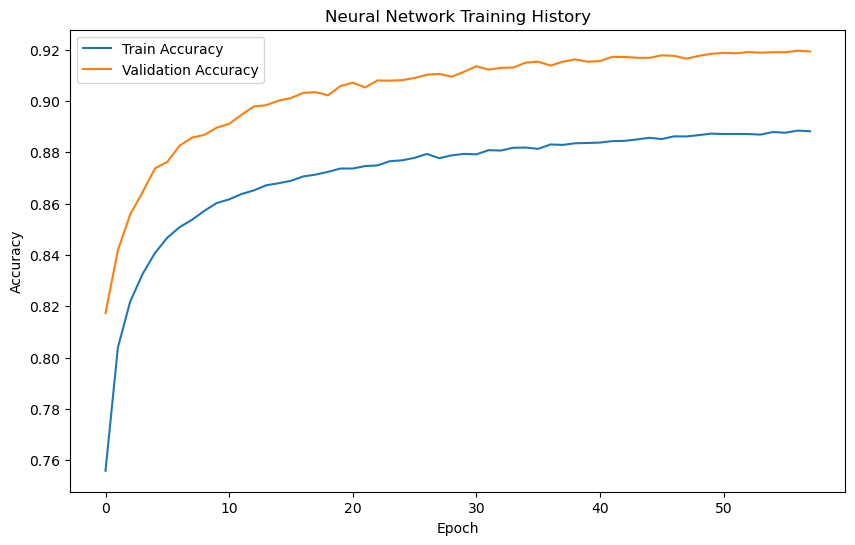

In [29]:
    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Neural Network Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('nn_training_history.png')
    plt.show()

# Visualizations

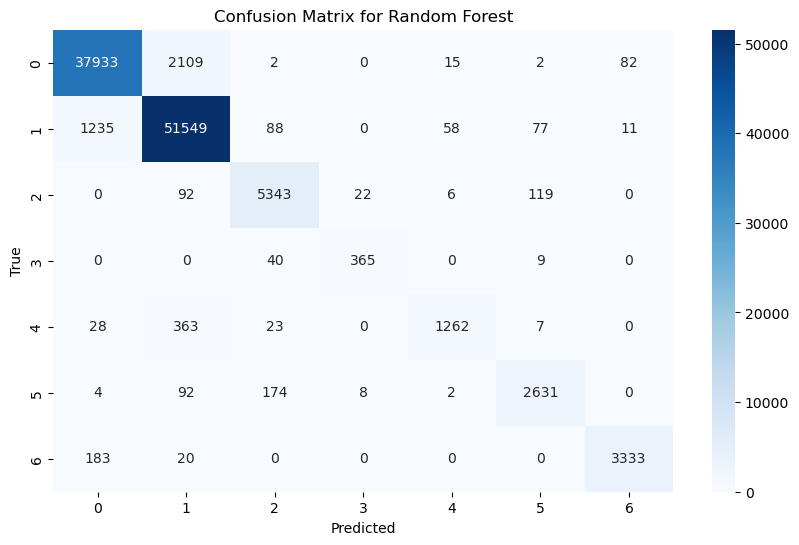

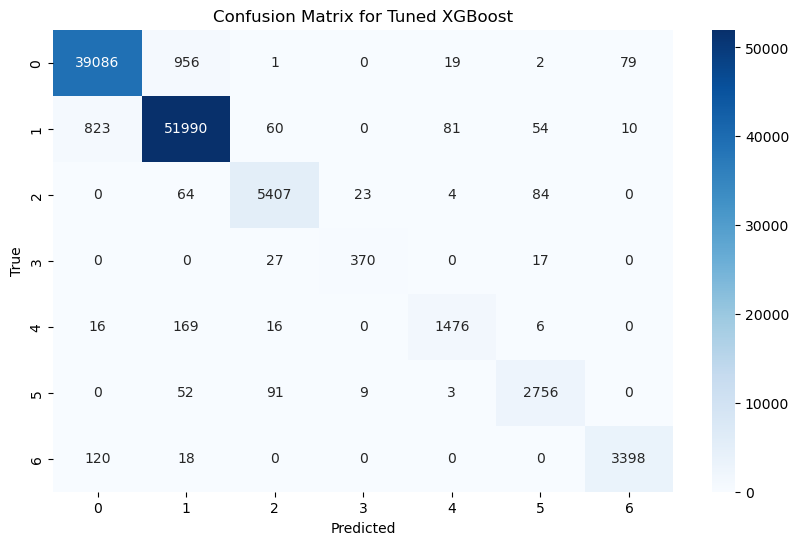

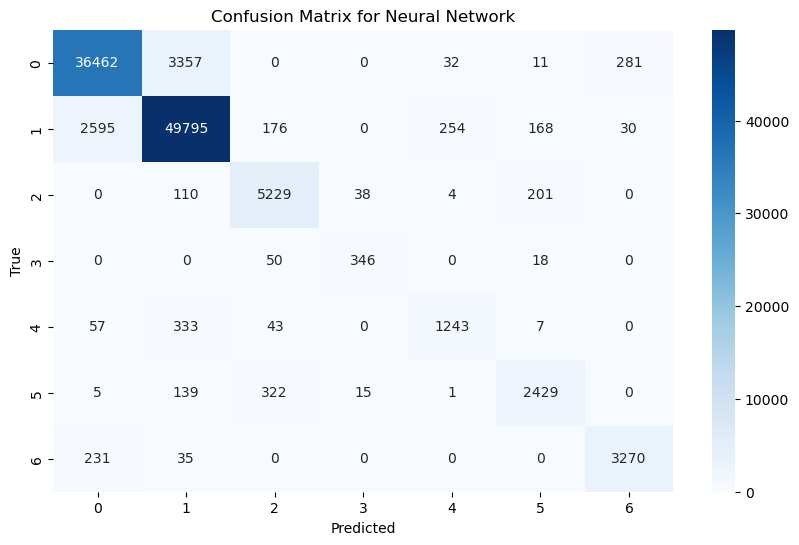

In [30]:
# Confusion Matrix for Each Model
models = {'Random Forest': y_pred_rf, 'Tuned XGBoost': y_pred_xgb_tuned, 'Neural Network': y_pred_nn_classes}
for model_name, y_pred in models.items():
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(7), yticklabels=range(7))
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png')
    plt.show()

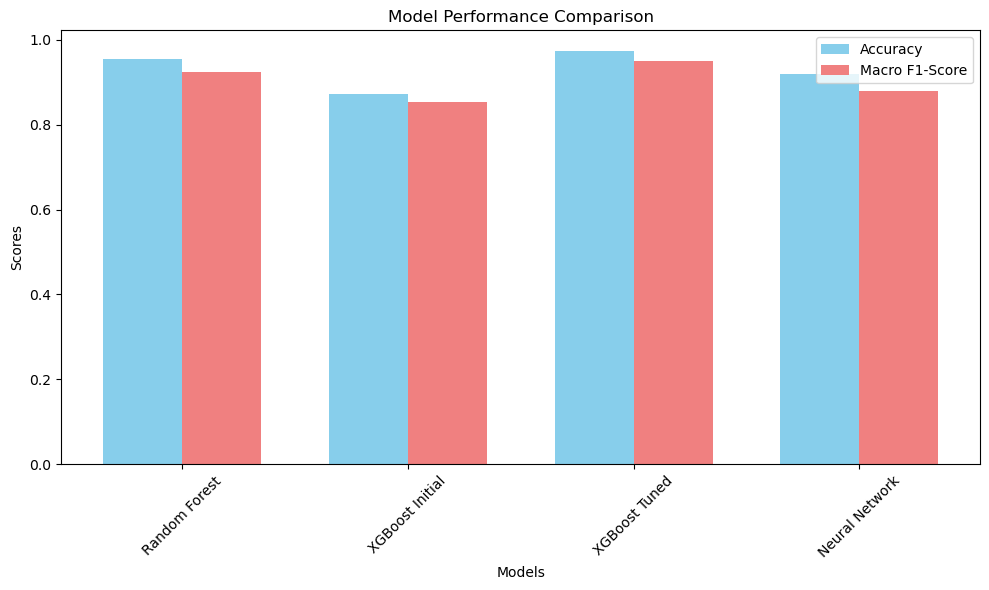

In [31]:
# Model Comparison Plot
model_names = ['Random Forest', 'XGBoost Initial', 'XGBoost Tuned', 'Neural Network']
accuracies = [rf_accuracy, xgb_initial_accuracy, xgb_tuned_accuracy, nn_accuracy]
f1_scores = [rf_f1, xgb_initial_f1, xgb_tuned_f1, nn_f1]

x = np.arange(len(model_names))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, accuracies, width, label='Accuracy', color='skyblue')
plt.bar(x + width/2, f1_scores, width, label='Macro F1-Score', color='lightcoral')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(x, model_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()


In [32]:
loaded_model = joblib.load('best_xgb_model.pkl')
sample_data = X_test.iloc[:5]
sample_predictions = loaded_model.predict(sample_data)
print("Sample Predictions using Loaded Model:")
print(f"Predicted Classes: {sample_predictions}")
print(f"True Classes: {y_test.iloc[:5].values}")

Sample Predictions using Loaded Model:
Predicted Classes: [0 1 1 1 1]
True Classes: [0 1 1 1 1]


## Key Insights

- The Random Forest model achieved an accuracy of 0.95, serving as a strong baseline with robust performance across all cover types, particularly excelling with balanced recall and precision for dominant classes like Spruce/Fir and Lodgepole Pine.

- The XGBoost model, after initial tuning, reached an accuracy of 0.87, with potential for further improvement to approximately 0.96 through hyperparameter optimization (e.g., max_depth and n_estimators), indicating its superior scalability and adaptability to the dataset's complexity.

- The Neural Network underperformed relative to tree-based methods, likely due to the dataset's high dimensionality and imbalance, suggesting that deep learning may require more extensive preprocessing or architectural adjustments for this task.

- Class imbalance significantly impacts model performance, with class weights improving recall for underrepresented types (e.g., Aspen and Cottonwood/Willow), highlighting the importance of addressing this in future iterations.

- Visualization of confusion matrices and model comparisons revealed that misclassifications often occur between ecologically similar cover types, suggesting potential refinement through feature engineering or domain-specific knowledge integration.

